# **U-Net Segmentation on Inria Building Dataset**

In [0]:
# !unzip dummy_Inria_data.zip

In [0]:
import os
import sys
import cv2
import time
import random
import keras
import numpy as np
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras import backend as keras
from skimage.transform import resize
from keras.utils import plot_model, Sequence
import keras.backend.tensorflow_backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate
from skimage.transform import resize, rotate, rescale, warp, AffineTransform


DataAugmnetation Class is for Augmenting the dataset.

Features:  Rotation
                   Scaling
                   Horizontal Flip
                   Verrtical Flip
                   Shear

In [0]:
class DataAugmentation():
    """ Class for data augmentation.

        Mainly helps when the training data is small

        Parameters: image, mask,
                    rotation angle (default = 90)
                    zoom_range (default = 1)
                    horizontal_flip (default = False)
                    vertical_flip (default = False)
                    activate (default = False)
    """

    def __init__(self, image, mask,
                rotation = 0,
                zoom_range = 1,
                horizontal_flip = False,
                vertical_flip = False,
                shear = 0,
                activate = False):

        self.image = image
        self.mask = mask
        self.rotation = rotation
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.shear = shear
        self.activate = activate

    def rotate_data(self):
        """ Rotation
        """
        self.image = rotate(self.image, self.rotation)
        self.mask = rotate(self.mask, self.rotation)
        return self.image, self.mask

    def rescale_data(self):
        """ Rescaling
        """
        height, width, _ = self.image.shape
        self.image = rescale(self.image, self.zoom_range)
        self.image = resize(self.image, (height, width))

        self.mask = rescale(self.mask, self.zoom_range)
        self.mask = resize(self.mask, (height, width))
        return self.image, self.mask

    def flip_horizontal_data(self):
        """ Flip Horizontally
        """
        if self.flip_horizontal == True:
            flipped_image = np.flip(self.image, 1)
            flipped_mask = np.flip(self.mask, 1)
            return flipped_image, flipped_mask

    def flip_vertically_data(self):
        """ Flip Vertically
        """
        if self.flip_vertically == True:
            flipped_image = np.flip(self.image, 0)
            flipped_mask = np.flip(self.mask, 0)
            return flipped_image, flipped_mask

    def shear_data(self):
        """ Shear
        """
        trans = AffineTransform(shear = 0.2)
        self.image = warp(self.image, inverse_map= trans)
        self.mask = warp(self.mask, inverse_map= trans)
        return self.image, self.mask

    def augment(self):
        if self.activate == True:
            images = []
            masks = []
            images.append(self.image)
            masks.append(self.mask)
            # print('Augmentation:: Image List Size: ',len(images))
            if self.rotation != 0:
                self.image, self.mask = self.rotate_data()
                images.append(self.image)
                masks.append(self.mask)

            if self.zoom_range != 1:
                self.image, self.mask = self.rescale_data()
                images.append(self.image)
                masks.append(self.mask)

            if self.horizontal_flip == True:
                self.image, self.mask = self.flip_horizontal_data()
                images.append(self.image)
                masks.append(self.mask)

            if self.vertical_flip == True:
                self.image, self.mask = self.flip_vertically_data()
                images.append(self.image)
                masks.append(self.mask)

            if self.shear != 0:
                self.image, self.mask = self.shear_data()
                images.append(self.image)
                masks.append(self.mask)
        else:
            images = []
            masks = []
            images.append(self.image)
            masks.append(self.mask)

        images = np.array(images)
        masks = np.array(masks)

        return images, masks

InriaDataLoader Class helps to load the data from the train directory. In the background it calls the DataAugmentation class. To avoid augmentation set the "aug" flag as "False"


In [0]:
from keras.utils import Sequence
class InriaDataLoader(Sequence):
    """ Load the training dataset for Inria Dataset from the
        data folder and put in an array

        Parameters: - data_path: Loads the datapath
                    - patch_size: Format the image sizes (default: 256x256)
                    - train_ids:

    """
    def __init__(self, data_ids, data_path, patch_size = 256,
                batch_size = 8, aug = False, rotation = 0,
                zoom_range = 1, horizontal_flip = False,
                vertical_flip = False, shear = 0):

        self.data_path = data_path
        self.data_ids = data_ids
        self.patch_size = patch_size
        self.batch_size = batch_size
        self.aug = aug
        self.rotation = rotation
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.shear = shear

    def __load__(self, data_name):
        """ Load an image and a mask from the data folder
            Parameters: Image name
        """
        image_name_path = os.path.join(self.data_path,'images/', data_name)
        mask_name_path = os.path.join(self.data_path, 'gt', data_name)

        image = cv2.imread(image_name_path, 1)
        image = cv2.resize(image, (self.patch_size,
                            self.patch_size))

        mask = cv2.imread(mask_name_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (self.patch_size,
                            self.patch_size))
        mask = mask[:, :, np.newaxis]

        image = image/255.
        
        mask = mask/255.

        return image, mask

    def __getitem__(self, index):
        """ Get all the images and masks in the data folder
            and put into array
        """
        if(index+1)*self.batch_size > len(self.data_ids):
            self.batch_size = len(self.data_ids) - index*self.batch_size

        files_batch = self.data_ids[index * \
            self.batch_size: (index + 1) * self.batch_size]

        images = []
        masks = []

        for file in files_batch:
            image, mask = self.__load__(file)
    
            aug = DataAugmentation(image, mask,
                                rotation =self.rotation,
                                zoom_range = self.zoom_range,
                                activate = self.aug)

            aug_images, aug_masks = aug.augment()

            for aug_image in aug_images:
                images.append(aug_image)

            for aug_mask in aug_masks:
                masks.append(aug_mask)
              

        images = np.array(images)
        masks = np.array(masks)

        return images, masks


    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.data_ids)/float(self.batch_size)))

Visualizer class helps to plot the image and mask

In [0]:
class Visualizer():
    """ Class for visualizing input image and corresponding
        mask

        Parameters: image
                    mask
    """
    def __init__(self, image, mask, image_size = 256):
        self.image = image
        self.mask = mask
        self.image_size = image_size

    def plot(self):
        fig = plt.figure()
        fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

        fig_a = fig.add_subplot(1, 2, 1)
        fig_a.set_title('Input Image')
        image = np.reshape(self.image[0]*255, 
                           (self.image_size, self.image_size))
        plt.imshow(image)

        fig_b = fig.add_subplot(1, 2, 2)
        fig_b.set_title('Output Mask')
        mask = np.reshape(self.mask[0]*255, 
                          (self.image_size, self.image_size))
        plt.imshow(mask)

        plt.show()


UNet class contains the architecture of U-Net 

In [0]:
class UNet():
    """ U-Net Model

        Parameters: - Image Size (default = 256)
                    - Kernel Size (default = (3, 3))
                    - Padding (default = 'same')
                    - Activation (default = 'relu')
                    - Pool Size (default = 2)
                    - Strides (default = 1)
                    - Max Pool Strides (default = 2)
                    - Up Sample (default = 2)
    """
    def __init__(self,
                image_size = 256,
                kernel_size = (3, 3),
                padding = 'same',
                activation = 'relu',
                pool_size = 2,
                strides = 1,
                max_pool_strides = 2,
                up_sample = 2):
        self.image_size = image_size
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.pool_size = pool_size
        self.strides = strides
        self.max_pool_strides = max_pool_strides
        self.up_sample = up_sample
    def network(self):
        f = [16, 32, 64, 128, 256]
        inputs = Input((self.image_size, self.image_size, 3))

        # p0 = inputs
        down1 = Conv2D(f[0],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(inputs)
        down2 = Conv2D(f[0],
                    kernel_size= self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation = self.activation)(down1)
        pool1 = MaxPool2D(pool_size = (self.pool_size, self.pool_size),
                    strides = (self.max_pool_strides,
                            self.max_pool_strides))(down2)

        down3 = Conv2D(f[1],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(pool1)
        down4 = Conv2D(f[1],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(down3)
        pool2 = MaxPool2D(pool_size = (self.pool_size, self.pool_size),
                    strides = (self.max_pool_strides,
                            self.max_pool_strides))(down4)

        down5 = Conv2D(f[2],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation = self.activation)(pool2)
        down6 = Conv2D(f[2],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(down5)
        pool3 = MaxPool2D(pool_size = (self.pool_size, self.pool_size),
                    strides = (self.max_pool_strides,
                            self.max_pool_strides))(down6)

        down7 = Conv2D(f[3],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(pool3)
        down8 = Conv2D(f[3],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(down7)
        pool4 = MaxPool2D(pool_size = (self.pool_size, self.pool_size),
                    strides = (self.max_pool_strides,
                            self.max_pool_strides))(down8)

        bn1 = Conv2D(f[4],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(pool4)
        bn2 = Conv2D(f[4],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(bn1)

        up_sample1 = UpSampling2D((self.up_sample, self.up_sample))(bn2)
        concat1 = Concatenate()([up_sample1, down8])
        up1 = Conv2D(f[3],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(concat1)
        up2 = Conv2D(f[3],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(up1)

        up_sample2 = UpSampling2D((self.up_sample, self.up_sample))(up2)
        concat2 = Concatenate()([up_sample2, down6])
        up3 = Conv2D(f[2],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(concat2)
        up4 = Conv2D(f[2],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(up3)

        up_sample3 = UpSampling2D((self.up_sample, self.up_sample))(up4)
        concat3 = Concatenate()([up_sample3, down4])
        up5 = Conv2D(f[1],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(concat3)
        up6 = Conv2D(f[1],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(up5)

        up_sample4 = UpSampling2D((self.up_sample, self.up_sample))(up6)
        concat4 = Concatenate()([up_sample4, down2])
        up7 = Conv2D(f[0],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(concat4)
        up8 = Conv2D(f[0],
                    kernel_size = self.kernel_size,
                    padding = self.padding,
                    strides= self.strides,
                    activation= self.activation)(up7)

        outputs = Conv2D(1, (1,1), padding = 'same',
                        activation= 'sigmoid')(up8)
        model = Model(inputs, outputs)

        return model

TrainUNet class helps to train the network 

In [0]:
class TrainUNet():
    """ Class for training U-Net Model

        Parameters: train_path       = train folder
                    patch_size      = 256x256
                    activate_aug    = False
                    rotation        = 0
                    zoom_range      = 1
                    horizontal_flip = False
                    vertical_flip   = False
                    shear           = 0
                    net             = U-Net
                    epochs          = 5
                    batch_size      = 1
                    learning_rate   = 0.2
                    val_percent     =
                    save_model      = False
                    activate_gpu    = False
    """
    def __init__(self,
                train_path,
                image_size = 256,
                activate_aug = False,
                rotation = 0,
                zoom_range = 1,
                horizontal_flip = False,
                vertical_flip = False,
                shear = 0,
                epochs = 20,
                batch_size = 8,
                learning_rate = 0.1,
                save_model = True,
                val_data_size = 10,
                evaluate = True):

        self.train_path = train_path
        self.image_size = image_size
        self.activate_aug = activate_aug
        self.rotation = rotation
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.shear = shear
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.save_model = save_model
        self.val_data_size = val_data_size
        self.evaluate = evaluate

    def train(self):
        print('''
Starting Training:

    Data Path:       {}
    Model:           {}
    Patch Size:      {}
    Augmentation:    {}
    Rotation:        {}
    Zoom Range:      {}
    Horizontal Flip: {}
    Vertical Flip:   {}
    Shear:           {}
    Epochs:          {}
    Batch Size:      {}
    Learning Rate:   {}
    Validation %:    {}
    Save Model:      {}
    Evaluate:        {}

        '''.format(str(self.train_path), str('U-Net'), self.image_size,
            self.activate_aug, self.rotation, self.zoom_range,
            self.horizontal_flip, self.vertical_flip, self.shear,
            self.epochs, self.batch_size, self.learning_rate,
            self.val_data_size, self.save_model, self.evaluate))

        images_path = os.path.join(self.train_path, 'images/')
        train_ids = next(os.walk(images_path))[2]

        valid_ids = train_ids[:self.val_data_size]
        train_ids = train_ids[self.val_data_size:]

        models = UNet()
        model = models.network()
        model.compile(optimizer = 'adam', 
                      loss = 'binary_crossentropy', metrics = ['acc'])
#         model.summary()

        train_gen = InriaDataLoader(train_ids,
                                    self.train_path,
                                    patch_size = self.image_size,
                                    batch_size = self.batch_size,
                                    aug = False,
                                    rotation = 0)

        valid_gen = InriaDataLoader(valid_ids,
                                    self.train_path,
                                    patch_size = self.image_size,
                                    batch_size = self.batch_size)

        x, y = train_gen.__getitem__(0)
        print(x.shape, y.shape)
        fig = plt.figure()
        fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(x[0])
        ax = fig.add_subplot(1,2,2)
        ax.imshow(np.reshape(y[0], (self.image_size, 
                                    self.image_size)), cmap = 'gray')
        
#         print(x[0])
        train_steps = len(train_ids) // self.batch_size
        valid_steps = len(valid_ids) // self.batch_size
        print(train_steps)
        model.fit_generator(train_gen,
                            validation_data = valid_gen,
                            steps_per_epoch = train_steps,
                            validation_steps = valid_steps,
                            epochs = self.epochs)
#         if self.save_model:
#             model.save('building_unet.h5')

#         plot_model(model, to_file = 'unet_architecture.png')

        if self.evaluate:
            image , mask = valid_gen.__getitem__(2)
            result = model.predict(image)
            result = result > 0.5
            viz = Visualizer(mask, result)
            viz.plot()


Starting Training:

    Data Path:       dummy_Inria_data/train
    Model:           U-Net
    Patch Size:      256
    Augmentation:    False
    Rotation:        0
    Zoom Range:      1
    Horizontal Flip: False
    Vertical Flip:   False
    Shear:           0
    Epochs:          20
    Batch Size:      8
    Learning Rate:   0.1
    Validation %:    10
    Save Model:      True
    Evaluate:        True

        
(8, 256, 256, 3) (8, 256, 256, 1)
123
Epoch 1/20
123/123 [==============================] - 23s 188ms/step - loss: 0.4545 - acc: 0.8339 - val_loss: 0.3748 - val_acc: 0.8037
Epoch 2/20
123/123 [==============================] - 19s 157ms/step - loss: 0.3431 - acc: 0.8481 - val_loss: 0.3598 - val_acc: 0.8337
Epoch 3/20
123/123 [==============================] - 19s 156ms/step - loss: 0.3077 - acc: 0.8711 - val_loss: 0.2527 - val_acc: 0.9002
Epoch 4/20
123/123 [==============================] - 19s 157ms/step - loss: 0.2803 - acc: 0.8831 - val_loss: 0.2676 - val_acc: 0.88

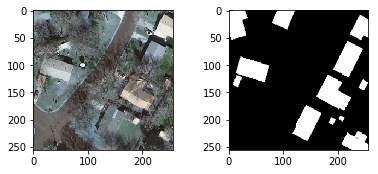

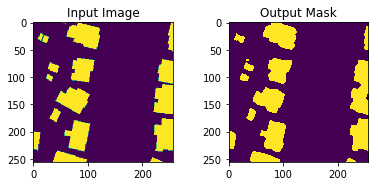

In [27]:
train_unet = TrainUNet(train_path='dummy_Inria_data/train')
train_unet.train()